# Symbolic Regression on an 8x8 Binary Image
This notebook demonstrates how to use **PySR** to fit a symbolic regression model to an 8x8 binary image using a custom `safe_mod` operator.

In [1]:
import numpy as np
from PIL import Image
from pysr import PySRRegressor
from sympy import symbols, Function
from sympy.utilities.lambdify import lambdify
from IPython.display import display

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Load and preprocess the image

In [2]:
# Load and binarize 8x8 image
img = Image.open("8x8grid.bmp").convert("1")
npa = np.array(img, dtype=int)

# Generate (x, y) coordinates for each pixel
X = np.array([[x, y] for x in range(8) for y in range(8)])
Y = npa.flatten()

## Define symbolic regression model with custom operator

In [3]:
# Define symbolic placeholder for safe_mod
safe_mod_sym = Function("safe_mod")

# Define symbolic regression model
model = PySRRegressor(
    maxsize=20,
    niterations=100,
    binary_operators=[
        "+",
        "safe_mod(x,y) = (x > 0 && y > 0) ? Float32(mod(x,y)) : Float32(NaN)"
    ],
    extra_sympy_mappings={"safe_mod": safe_mod_sym},
)

model.fit(X, Y)

D:\NewPython\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.500e-01  0.000e+00  y = 0.50001
5           2.500e-01  1.490e-08  y = safe_mod(x₁ + 1.5, 1)
7           8.882e-16  1.664e+01  y = safe_mod((x₁ + x₀) + 3, 2)
───────────────────────────────────────────────────────────────────────────────────────────────────


,model_selection,'best'
,binary_operators,"['+', 'safe_mod(x,y) = (x > 0...od(x,y)) : Float32(NaN)']"
,unary_operators,None
,expression_spec,None
,niterations,100
,populations,31
,population_size,27
,max_evals,None
,maxsize,20
,maxdepth,None
,warmup_maxsize_by,None


  - outputs\20250930_023104_q6WMbB\hall_of_fame.csv


## Extract and test the best symbolic expression

In [4]:
# Extract best symbolic expression
best = model.sympy()
print("Best symbolic expression:", best)

# Define safe_mod for numpy
def safe_mod(x, y):
    return np.float32(x % y) if y != 0 else np.float32(np.nan)

# Convert to NumPy-compatible function
x0, x1 = symbols("x0 x1")
f = lambdify((x0, x1), best, modules=[{"safe_mod": safe_mod}, "numpy"])

Best symbolic expression: safe_mod(x0 + x1 + 3.0000002, 2.0)


## Evaluate model over grid and visualize results

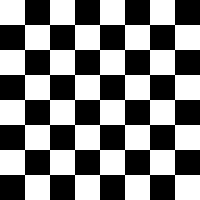

In [5]:
# Predict values for grid
predicted = np.array([f(x, y) for x, y in X])
binary_image = (predicted > 0.5).astype(np.uint8).reshape((8, 8))

# Show and save output
img_out = Image.fromarray(binary_image * 255).convert("1")
resiz=img_out.resize((200,200))
display(resiz)
img_out.save("genimg.bmp")

## Compare accuracy with original image

In [6]:
accuracy = np.mean(binary_image.flatten() == Y)
print(f"Pixel-wise accuracy: {accuracy:.2%}")

Pixel-wise accuracy: 100.00%
